## imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

import shap
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.metrics import roc_auc_score, f1_score, r2_score

from sklearn.preprocessing import OneHotEncoder

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

C:\Users\vush6\PycharmProjects\OLYMPIADS\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load postprocessed data

In [2]:
train_df = pd.read_csv('ml_data.csv')
TARGET = '1_KPI данные понедельно АлфаРМ_Продажи, рубли'

In [3]:
small_df = train_df[~train_df[TARGET].isna()]

## init model for features selection

In [5]:
def train_regressor_model(X, y, n_splits, cat_features, model):
    clfs = []
    scores = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    for train_index, test_index in tscv.split(X):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = model.copy()
    
        clfs.append(clf)
    
        clf.fit(
            X_train, y_train,
            eval_set=(X_test, y_test),
            verbose=100,
            use_best_model=True,
            plot=False)
    
        y_pred = clf.predict(X_test)
        score = mean_absolute_percentage_error(y_test, y_pred)  # np.mean(np.array(y_pred == y_test))
        scores.append(score)
        print(f"fold: MAPE score: {score}")
    
    assert len(clfs) == n_splits
    print(
        "====>>> mean MAPE: " + str(np.mean(scores, dtype="float32")) + " <<<====", np.std(scores).round(4), "\n"
    )
    return clfs

## feature selection

In [6]:
n_splits = 5

train_columns = [x for x in small_df.columns if x not in [
    # '1_KPI \nданные понедельно АлфаРМ_Продажи, рубли',
    'Пеиод__Начало нед',
    '1_KPI данные понедельно АлфаРМ_Продажи, упаковки',
    # 'Пеиод__Начало нед'
]] 
train_df = small_df.copy()[train_columns]
cat_features = []

for col in cat_features:
    train_df[col] = train_df[col].astype('category')

X = train_df.drop(columns=[TARGET])
y = train_df[TARGET]

In [7]:
model = CatBoostRegressor(
            depth=5,
            iterations=3500,
            learning_rate=0.06,
            loss_function='MAPE', 
            eval_metric="MAPE", 
            custom_metric="MAPE",
            boosting_type="Ordered",
            
            # Главная фишка катбуста - работа с категориальными признаками
            cat_features=cat_features,
            # ignored_features = ignored_features,
            
            # Регуляризация и ускорение
            colsample_bylevel=0.098,
            subsample=0.95,
            l2_leaf_reg=9,
            min_data_in_leaf=243,
            max_bin=187,
            random_strength=1,
            
            # Параметры ускорения
            task_type="CPU",    
            thread_count=-1,
            bootstrap_type="Bernoulli", 
            
            # Важное!
            random_seed=7575,
            # auto_class_weights="SqrtBalanced",
            early_stopping_rounds=50)

In [8]:
clfs = train_regressor_model(X, y, n_splits, cat_features, model)

0:	learn: 0.2855769	test: 0.2742196	best: 0.2742196 (0)	total: 151ms	remaining: 8m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1742983167
bestIteration = 36

Shrink model to first 37 iterations.
fold: MAPE score: 1.3652383764528888
0:	learn: 0.2793781	test: 0.6897453	best: 0.6897453 (0)	total: 4.9ms	remaining: 17.2s
100:	learn: 0.0454578	test: 0.5988263	best: 0.5973922 (95)	total: 565ms	remaining: 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5953479879
bestIteration = 132

Shrink model to first 133 iterations.
fold: MAPE score: 2.425982606278308
0:	learn: 0.3980921	test: 0.6835351	best: 0.6835351 (0)	total: 7.75ms	remaining: 27.1s
100:	learn: 0.0658390	test: 0.3743398	best: 0.3724776 (85)	total: 616ms	remaining: 20.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3724776084
bestIteration = 85

Shrink model to first 86 iterations.
fold: MAPE score: 1.6142113969435243
0:	learn: 0.4500001	test: 0.2883607	best: 0.

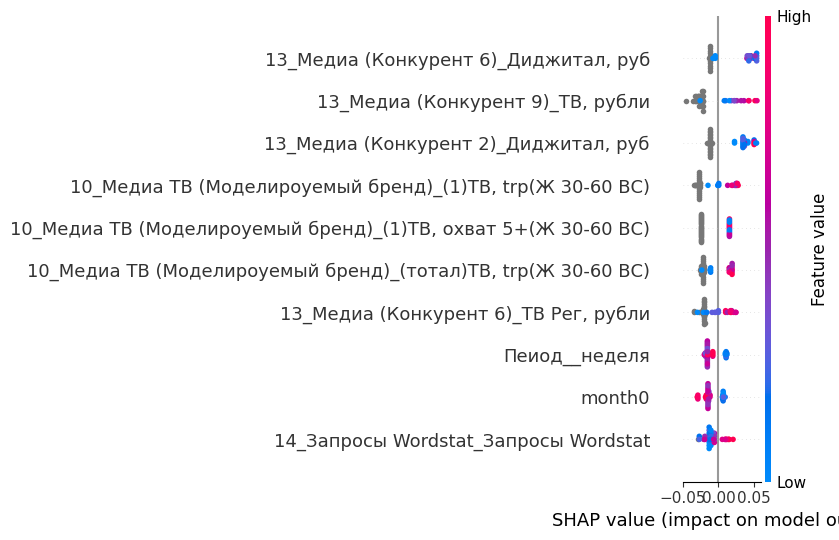

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
explainer = shap.TreeExplainer(clfs[0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=10)

In [10]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['feature_importance_vals'] = feature_importance['feature_importance_vals'].round(2)
feature_importance.head(20).col_name.values

array(['13_Медиа (Конкурент 6)_Диджитал, руб',
       '13_Медиа (Конкурент 9)_ТВ, рубли',
       '13_Медиа (Конкурент 2)_Диджитал, руб',
       '10_Медиа ТВ (Моделироуемый бренд)_(1)ТВ, trp(Ж 30-60 ВС)',
       '10_Медиа ТВ (Моделироуемый бренд)_(1)ТВ, охват 5+(Ж 30-60 ВС)',
       '10_Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, trp(Ж 30-60 ВС)',
       '13_Медиа (Конкурент 6)_ТВ Рег, рубли', 'Пеиод__неделя', 'month0',
       '14_Запросы Wordstat_Запросы Wordstat',
       '6_статистика заболеваемости_Статистика заболеваемости',
       '13_Медиа (Конкурент 12)_ТВ Рег, рубли',
       '13_Медиа (Конкурент 2)_Итого',
       '13_Медиа (Конкурент 13)_ТВ, охват 5+(Ж 30-60 ВС)',
       '13_Медиа (Конкурент 3)_Итого',
       '13_Медиа (Конкурент 12)_ТВ, рубли',
       '13_Медиа (Конкурент 6)_Итого',
       '13_Медиа (Конкурент 12)_ТВ, trp(Ж 30-60 ВС)',
       '13_Медиа (Конкурент 13)_Итого',
       '13_Медиа (Конкурент 13)_ТВ, trp(Ж 30-60 ВС)'], dtype=object)

## prophet training

In [11]:
COLUMNS_TO_PREDICT = [
   TARGET,
   '10_Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, trp(Ж 30-60 ВС)',
   '14_Запросы Wordstat_Запросы Wordstat',
   '10_Медиа ТВ (Моделироуемый бренд)_(1)ТВ, охват 5+(Ж 30-60 ВС)',
   '10_Медиа ТВ (Моделироуемый бренд)_(1)ТВ, trp(Ж 30-60 ВС)',
   '13_Медиа (Конкурент 3)_ТВ Рег, рубли',
   '13_Медиа (Конкурент 3)_Итого',
   '6_статистика заболеваемости_Статистика заболеваемости',
   '13_Медиа (Конкурент 13)_ТВ, рубли',
   '13_Медиа (Конкурент 13)_ТВ, trp(Ж 30-60 ВС)',
   '13_Медиа (Конкурент 13)_Итого',
   '13_Медиа (Конкурент 9)_ТВ, рубли',
   '13_Медиа (Конкурент 13)_ТВ, охват 5+(Ж 30-60 ВС)',
   '13_Медиа (Конкурент 7)_Итого',
   '10_Медиа ТВ (Моделироуемый бренд)_(тотал)ТВ, охват 5+(Ж 30-60 ВС)',
   '13_Медиа (Конкурент 2)_Итого',
   '13_Медиа (Конкурент 12)_ТВ, охват 5+(Ж 30-60 ВС)',
   '11_Медиа Диджитал (Моделируемый бренд)_Диджитал, рубли',
   '13_Медиа (Конкурент 12)_ТВ Рег, рубли'
]

COLUMNS_WITHOUT_LAG = [
    'month0', 'Пеиод__неделя'
]

In [12]:
predicts_df = pd.DataFrame()
small_df['Пеиод__Начало нед'] = pd.to_datetime(small_df['Пеиод__Начало нед'])
predicts_df['timestamp'] = [small_df.iloc[-1]['Пеиод__Начало нед'] + pd.Timedelta(days=7 * (i + 1)) for i in range(proph_df.shape[0] + 29)]

for i, column_name in enumerate(COLUMNS_TO_PREDICT):
    tmp_df = pd.DataFrame()
    tmp_df['ds'] = small_df['Пеиод__Начало нед'] # .iloc[:train_selected.shape[0]]
    tmp_df['y'] = small_df[COLUMNS_TO_PREDICT[i]].fillna(0)
    
    model = Prophet().fit(tmp_df)
    
    tmp_df = pd.DataFrame()
    tmp_df['ds'] = predicts_df['timestamp']

    predicts_df[column_name] = model.predict(tmp_df)['yhat']
    
    # print(column_name, 'MAPE', mean_absolute_percentage_error(model.predict(tmp_df)['yhat'], test_selected[COLUMNS_TO_PREDICT[i]].fillna(0)),
    # 'RSQ', r2_score(model.predict(tmp_df)['yhat'], test_selected[COLUMNS_TO_PREDICT[i]].fillna(0)))
    
    # plt.plot(range(train_selected.shape[0], small_df.shape[0]), model.predict(tmp_df)['yhat'])
    # plt.plot(small_df[COLUMNS_TO_PREDICT[i]]);

22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:39 - cmdstanpy - INFO - Chain [1] done processing
22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:39 - cmdstanpy - INFO - Chain [1] done processing
22:22:39 - cmdstanpy - INFO - Chain [1] start processing
22:22:39 - cmdstanpy - INFO - Chain [1] done processing
22:22:40 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing
22:22:40 - cmdstanpy - INFO - Chain [1] start processing
22:22:40 - cmdstanpy - INFO - Chain [1] done processing
22:22:41 - cmdstanpy - INFO - Chain [1] start processing
22:22:41 - cmdstanpy - INFO - Chain [1] done processing
22:22:41 - cmdstanpy - INFO - Chain [1] start processing
22:22:41 - cmdstanpy - INFO - Chain [1] done processing
22:22:41 - cmdstanpy - INFO - Chain [1] start processing
22:22:41 - cmdstanpy - INFO - Chain [1]

## predict

In [13]:
TARGET = '1_KPI данные понедельно АлфаРМ_Продажи, рубли'

In [17]:
preds_df = pd.read_csv('predicts.csv')

subm_df = pd.DataFrame()
subm_df['week'] = preds_df['Пеиод__Начало нед'].map(lambda x: pd.to_datetime(x).strftime('%d.%m.%Y'))
subm_df['revenue'] = preds_df[TARGET]

subm_df.to_csv('subm_proph.csv', index=False)

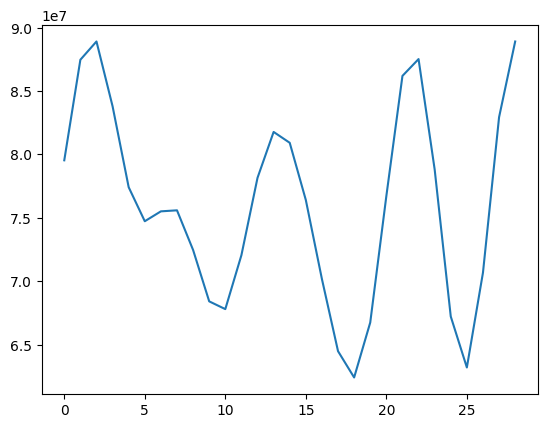

In [20]:
plt.plot(subm_df['revenue']);